In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/models')
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/data')
sys.path.append('/Users/dmitry/Desktop/Thesis/topics_ds/pytorch')

In [3]:
import numpy as np

import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

from tqdm import tqdm

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
from models import models as keras_models
from data import data
from pytorch import torch_models

In [5]:
IMG_LEN = 1024
TXT_LEN = 300
N_CLASSES = 50

### Loading

In [6]:
x_img, x_txt, y = data.get_unpacked_data()

### Splitting

In [7]:
x_img_train, x_img_test, x_txt_train, x_txt_test, y_train, y_test = train_test_split(
    x_img, 
    x_txt, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

x_img_train, x_img_val, x_txt_train, x_txt_val, y_train, y_val = train_test_split(
    x_img_train,
    x_txt_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

### Scaling

In [8]:
img_sscaler = StandardScaler()
img_sscaler.fit(x_img_train)

x_img_train = img_sscaler.transform(x_img_train)
x_img_val = img_sscaler.transform(x_img_val)
x_img_test = img_sscaler.transform(x_img_test)

txt_sscaler = StandardScaler()
txt_sscaler.fit(x_txt_train)

x_txt_train = txt_sscaler.transform(x_txt_train)
x_txt_val = txt_sscaler.transform(x_txt_val)
x_txt_test = txt_sscaler.transform(x_txt_test)

### Converting to tensors

In [9]:
x_img_train_t = torch.tensor(x_img_train)
x_img_val_t = torch.tensor(x_img_val)
x_img_test_t = torch.tensor(x_img_test)

x_txt_train_t = torch.tensor(x_txt_train)
x_txt_val_t = torch.tensor(x_txt_val)
x_txt_test_t = torch.tensor(x_txt_test)

y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

### Converting to datasets

In [10]:
train_ds = TensorDataset(x_img_train_t, x_txt_train_t, y_train_t)
val_ds = TensorDataset(x_img_val_t, x_txt_val_t, y_val_t)
test_ds = TensorDataset(x_img_test_t, x_txt_test_t, y_test_t)

### Creating loaders

In [11]:
BATCH_SIZE = 1024

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

## Minibatch generating function

In [12]:
def get_minibatch(
    n_tasks, 
    n_classes_per_task, 
    n_samples_per_class, 
    x_img_cur, x_txt_cur, y_cur
):    
    n_samples_per_task = n_classes_per_task * n_samples_per_class
    
    x_img_mb = torch.zeros(n_tasks, n_samples_per_task, IMG_LEN)
    x_txt_mb = torch.zeros(n_tasks, n_samples_per_task, TXT_LEN)
    y_mb = torch.zeros(n_tasks, n_samples_per_task, N_CLASSES)
    
    print('MINIBATCH GENERATION')
    for task in tqdm(range(n_tasks)):
        classes = np.random.choice(N_CLASSES, n_classes_per_task, replace=False)
        i = 0
        for class_num, cur_class in enumerate(classes):
            class_inds = np.where((y_cur==to_categorical(cur_class, N_CLASSES)).all(axis=1))[0]
            example_inds = np.random.choice(
                class_inds, 
                min(n_samples_per_class, len(class_inds)), 
                replace=False
            ) 
            x_img_mb[task][i : i + len(example_inds)] = torch.tensor(x_img_cur[example_inds])
            x_txt_mb[task][i : i + len(example_inds)] = torch.tensor(x_txt_cur[example_inds])
            y_mb[task][i : i + len(example_inds)] = torch.tensor(y_cur[example_inds])
            i += len(example_inds)
            
    return x_img_mb, x_txt_mb, y_mb 

### Creating learner

In [13]:
norm_model = torch_models.NormModel()
norm_optimizer = optim.Adam(norm_model.parameters(), lr=0.001)
norm_writer = SummaryWriter('runs/subtask')

### Fitting

In [14]:
train_loss_history = []
val_acc_history = []

In [15]:
EPOCHS = 150
for epoch in range(EPOCHS):
    print('EPOCH #', epoch)
    
    n_tasks = 5000
    x_img_mb, x_txt_mb, y_mb = get_minibatch(
        n_tasks=n_tasks, 
        n_classes_per_task=2, 
        n_samples_per_class=32, 
        x_img_cur=x_img_train, 
        x_txt_cur=x_txt_train, 
        y_cur=y_train
    )
    
    print('TRAINING')
    for task in tqdm(range(n_tasks)):
        x_img_cur = x_img_mb[task]
        x_txt_cur = x_txt_mb[task]
        y_cur = y_mb[task]
        
        norm_model.zero_grad()
        output = norm_model(x_img_cur.float(), x_txt_cur.float())
        loss = F.nll_loss(output, torch.argmax(y_cur, dim=1))
        
        train_loss_history.append(loss)
        
        loss.backward()
        norm_optimizer.step()
        norm_writer.add_scalar('train_loss', loss, epoch * 5000 + task)
    
    print('loss:', loss)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x_img, x_txt, y in val_loader:
            output = norm_model(x_img.float(), x_txt.float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == torch.argmax(y, dim=1)[idx]:
                    correct += 1
                total += 1
    
    print('val acc:', correct/total)
    val_acc_history.append(correct/total)
                
                
    norm_writer.add_scalar('val_acc', correct/total, epoch)

EPOCH # 0


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:08<00:00, 38.95it/s]


loss: tensor(1.8674, grad_fn=<NllLossBackward>)
val acc: 0.506607799852833
EPOCH # 1


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:18<00:00, 36.14it/s]


loss: tensor(1.5219, grad_fn=<NllLossBackward>)
val acc: 0.5366887417218543
EPOCH # 2


  0%|          | 1/5000 [00:00<15:30,  5.38it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.40it/s]


loss: tensor(1.8928, grad_fn=<NllLossBackward>)
val acc: 0.5421633554083886
EPOCH # 3


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:17<00:00, 36.33it/s]


loss: tensor(0.5835, grad_fn=<NllLossBackward>)
val acc: 0.5433995584988962
EPOCH # 4


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:07<00:00, 39.09it/s]


loss: tensor(1.2831, grad_fn=<NllLossBackward>)
val acc: 0.5454893303899926
EPOCH # 5


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:16<00:00, 36.73it/s]


loss: tensor(1.6002, grad_fn=<NllLossBackward>)
val acc: 0.5471081677704194
EPOCH # 6


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:07<00:00, 39.30it/s]


loss: tensor(1.1689, grad_fn=<NllLossBackward>)
val acc: 0.5299484915378955
EPOCH # 7


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:11<00:00, 38.07it/s]


loss: tensor(1.5749, grad_fn=<NllLossBackward>)
val acc: 0.5397792494481236
EPOCH # 8


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:14<00:00, 37.26it/s]


loss: tensor(2.0116, grad_fn=<NllLossBackward>)
val acc: 0.551523178807947
EPOCH # 9


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:06<00:00, 39.67it/s]


loss: tensor(1.5856, grad_fn=<NllLossBackward>)
val acc: 0.552317880794702
EPOCH # 10


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:07<00:00, 39.29it/s]


loss: tensor(0.5002, grad_fn=<NllLossBackward>)
val acc: 0.5520235467255334
EPOCH # 11


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.71it/s]


loss: tensor(1.0394, grad_fn=<NllLossBackward>)
val acc: 0.5434878587196468
EPOCH # 12


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:15<00:00, 37.02it/s]


loss: tensor(0.8926, grad_fn=<NllLossBackward>)
val acc: 0.5524061810154526
EPOCH # 13


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:08<00:00, 39.06it/s]


loss: tensor(1.2441, grad_fn=<NllLossBackward>)
val acc: 0.5500220750551876
EPOCH # 14


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:15<00:00, 36.86it/s]


loss: tensor(0.9771, grad_fn=<NllLossBackward>)
val acc: 0.5428108903605592
EPOCH # 15


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:20<00:00, 35.54it/s]


loss: tensor(0.9238, grad_fn=<NllLossBackward>)
val acc: 0.5470787343635026
EPOCH # 16


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:11<00:00, 38.05it/s]


loss: tensor(2.1266, grad_fn=<NllLossBackward>)
val acc: 0.5549963208241354
EPOCH # 17


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.43it/s]


loss: tensor(0.3359, grad_fn=<NllLossBackward>)
val acc: 0.5545548197203827
EPOCH # 18


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:15<00:00, 36.78it/s]


loss: tensor(0.6394, grad_fn=<NllLossBackward>)
val acc: 0.5531125827814569
EPOCH # 19


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.64it/s]


loss: tensor(0.6269, grad_fn=<NllLossBackward>)
val acc: 0.5400441501103753
EPOCH # 20


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.77it/s]


loss: tensor(0.9480, grad_fn=<NllLossBackward>)
val acc: 0.5565562913907285
EPOCH # 21


  0%|          | 1/5000 [00:00<15:26,  5.39it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:10<00:00, 38.44it/s]


loss: tensor(0.1238, grad_fn=<NllLossBackward>)
val acc: 0.5472847682119205
EPOCH # 22


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:14<00:00, 37.22it/s]


loss: tensor(0.6975, grad_fn=<NllLossBackward>)
val acc: 0.5563502575423105
EPOCH # 23


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:16<00:00, 36.63it/s]


loss: tensor(0.6481, grad_fn=<NllLossBackward>)
val acc: 0.5555849889624724
EPOCH # 24


  0%|          | 1/5000 [00:00<16:32,  5.03it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:10<00:00, 38.37it/s]


loss: tensor(0.5072, grad_fn=<NllLossBackward>)
val acc: 0.5532008830022075
EPOCH # 25


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:18<00:00, 36.21it/s]


loss: tensor(0.8689, grad_fn=<NllLossBackward>)
val acc: 0.5417512877115526
EPOCH # 26


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:06<00:00, 39.45it/s]


loss: tensor(0.8417, grad_fn=<NllLossBackward>)
val acc: 0.549168506254599
EPOCH # 27


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:14<00:00, 37.06it/s]


loss: tensor(0.4245, grad_fn=<NllLossBackward>)
val acc: 0.5494334069168506
EPOCH # 28


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.46it/s]


loss: tensor(1.0294, grad_fn=<NllLossBackward>)
val acc: 0.555261221486387
EPOCH # 29


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:08<00:00, 39.02it/s]


loss: tensor(0.9672, grad_fn=<NllLossBackward>)
val acc: 0.5549080206033848
EPOCH # 30


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.59it/s]


loss: tensor(0.2374, grad_fn=<NllLossBackward>)
val acc: 0.551523178807947
EPOCH # 31


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:17<00:00, 36.25it/s]


loss: tensor(0.0852, grad_fn=<NllLossBackward>)
val acc: 0.5555555555555556
EPOCH # 32


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:10<00:00, 38.37it/s]


loss: tensor(0.6804, grad_fn=<NllLossBackward>)
val acc: 0.5482266372332597
EPOCH # 33


  0%|          | 1/5000 [00:00<14:42,  5.67it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.87it/s]


loss: tensor(0.7329, grad_fn=<NllLossBackward>)
val acc: 0.5506696100073584
EPOCH # 34


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.77it/s]


loss: tensor(0.8393, grad_fn=<NllLossBackward>)
val acc: 0.5444002943340692
EPOCH # 35


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.54it/s]


loss: tensor(0.6160, grad_fn=<NllLossBackward>)
val acc: 0.5456953642384106
EPOCH # 36


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:11<00:00, 38.02it/s]


loss: tensor(0.4868, grad_fn=<NllLossBackward>)
val acc: 0.5489919058130979
EPOCH # 37


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:14<00:00, 37.09it/s]


loss: tensor(0.6265, grad_fn=<NllLossBackward>)
val acc: 0.5493156732891832
EPOCH # 38


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:10<00:00, 38.35it/s]


loss: tensor(1.3600, grad_fn=<NllLossBackward>)
val acc: 0.5544370860927152
EPOCH # 39


  0%|          | 1/5000 [00:00<14:08,  5.89it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.61it/s]


loss: tensor(0.5708, grad_fn=<NllLossBackward>)
val acc: 0.5527888153053716
EPOCH # 40


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.58it/s]


loss: tensor(0.1279, grad_fn=<NllLossBackward>)
val acc: 0.549757174392936
EPOCH # 41


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.72it/s]


loss: tensor(0.6670, grad_fn=<NllLossBackward>)
val acc: 0.5526416482707873
EPOCH # 42


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:11<00:00, 38.06it/s]


loss: tensor(0.2345, grad_fn=<NllLossBackward>)
val acc: 0.552494481236203
EPOCH # 43


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:10<00:00, 38.24it/s]


loss: tensor(1.8304, grad_fn=<NllLossBackward>)
val acc: 0.544841795437822
EPOCH # 44


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:11<00:00, 37.93it/s]


loss: tensor(0.0520, grad_fn=<NllLossBackward>)
val acc: 0.5553200883002207
EPOCH # 45


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:25<00:00, 34.39it/s]


loss: tensor(0.5718, grad_fn=<NllLossBackward>)
val acc: 0.5540544518027962
EPOCH # 46


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.57it/s]


loss: tensor(0.7278, grad_fn=<NllLossBackward>)
val acc: 0.5508462104488595
EPOCH # 47


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:02<00:00, 40.68it/s]


loss: tensor(0.3137, grad_fn=<NllLossBackward>)
val acc: 0.547991169977925
EPOCH # 48


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.67it/s]


loss: tensor(0.9996, grad_fn=<NllLossBackward>)
val acc: 0.5508167770419427
EPOCH # 49


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:07<00:00, 39.19it/s]


loss: tensor(1.2878, grad_fn=<NllLossBackward>)
val acc: 0.5563208241353936
EPOCH # 50


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:04<00:00, 40.31it/s]


loss: tensor(0.9051, grad_fn=<NllLossBackward>)
val acc: 0.5468432671081678
EPOCH # 51


  0%|          | 1/5000 [00:00<13:13,  6.30it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:06<00:00, 39.45it/s]


loss: tensor(0.3606, grad_fn=<NllLossBackward>)
val acc: 0.5540250183958794
EPOCH # 52


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.63it/s]


loss: tensor(0.7359, grad_fn=<NllLossBackward>)
val acc: 0.5503164091243562
EPOCH # 53


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:03<00:00, 40.61it/s]


loss: tensor(1.0198, grad_fn=<NllLossBackward>)
val acc: 0.5526122148638705
EPOCH # 54


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:08<00:00, 38.77it/s]


loss: tensor(1.8780, grad_fn=<NllLossBackward>)
val acc: 0.5483149374540103
EPOCH # 55


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:19<00:00, 35.94it/s]


loss: tensor(0.8061, grad_fn=<NllLossBackward>)
val acc: 0.5572038263428992
EPOCH # 56


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.61it/s]


loss: tensor(0.3190, grad_fn=<NllLossBackward>)
val acc: 0.5464900662251656
EPOCH # 57


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:19<00:00, 35.89it/s]


loss: tensor(0.2436, grad_fn=<NllLossBackward>)
val acc: 0.551140544518028
EPOCH # 58


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:07<00:00, 39.10it/s]


loss: tensor(0.8105, grad_fn=<NllLossBackward>)
val acc: 0.5483443708609271
EPOCH # 59


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:04<00:00, 40.16it/s]


loss: tensor(0.7196, grad_fn=<NllLossBackward>)
val acc: 0.5508756438557763
EPOCH # 60


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.50it/s]


loss: tensor(0.6669, grad_fn=<NllLossBackward>)
val acc: 0.5469315673289183
EPOCH # 61


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:30<00:00, 23.79it/s]


loss: tensor(0.7506, grad_fn=<NllLossBackward>)
val acc: 0.547785136129507
EPOCH # 62


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:36<00:00, 31.99it/s]


loss: tensor(0.1451, grad_fn=<NllLossBackward>)
val acc: 0.5534363502575423
EPOCH # 63


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:24<00:00, 34.60it/s]


loss: tensor(0.4864, grad_fn=<NllLossBackward>)
val acc: 0.546195732155997
EPOCH # 64


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.65it/s]


loss: tensor(1.2242, grad_fn=<NllLossBackward>)
val acc: 0.5529948491537896
EPOCH # 65


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:17<00:00, 36.43it/s]


loss: tensor(0.4753, grad_fn=<NllLossBackward>)
val acc: 0.5532303164091243
EPOCH # 66


  0%|          | 1/5000 [00:00<14:37,  5.70it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:09<00:00, 38.60it/s]


loss: tensor(0.4405, grad_fn=<NllLossBackward>)
val acc: 0.5511994113318617
EPOCH # 67


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:14<00:00, 37.26it/s]


loss: tensor(0.2898, grad_fn=<NllLossBackward>)
val acc: 0.5460779985283296
EPOCH # 68


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:15<00:00, 36.79it/s]


loss: tensor(0.3147, grad_fn=<NllLossBackward>)
val acc: 0.5491979396615159
EPOCH # 69


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:21<00:00, 35.26it/s]


loss: tensor(0.5707, grad_fn=<NllLossBackward>)
val acc: 0.5499043414275202
EPOCH # 70


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:23<00:00, 34.74it/s]


loss: tensor(0.7450, grad_fn=<NllLossBackward>)
val acc: 0.5477262693156733
EPOCH # 71


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:15<00:00, 36.78it/s]


loss: tensor(0.6286, grad_fn=<NllLossBackward>)
val acc: 0.552111846946284
EPOCH # 72


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:21<00:00, 35.39it/s]


loss: tensor(0.4426, grad_fn=<NllLossBackward>)
val acc: 0.5462251655629139
EPOCH # 73


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:16<00:00, 36.62it/s]


loss: tensor(0.8228, grad_fn=<NllLossBackward>)
val acc: 0.5466077998528329
EPOCH # 74


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:04<00:00, 40.16it/s]


loss: tensor(0.4709, grad_fn=<NllLossBackward>)
val acc: 0.5480206033848418
EPOCH # 75


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.47it/s]


loss: tensor(0.4020, grad_fn=<NllLossBackward>)
val acc: 0.5510522442972774
EPOCH # 76


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:15<00:00, 25.62it/s]


loss: tensor(0.4237, grad_fn=<NllLossBackward>)
val acc: 0.5544665194996321
EPOCH # 77


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:23<00:00, 24.56it/s] 


loss: tensor(1.2699, grad_fn=<NllLossBackward>)
val acc: 0.5539072847682119
EPOCH # 78


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [04:03<00:00, 20.53it/s]


loss: tensor(0.4559, grad_fn=<NllLossBackward>)
val acc: 0.5497277409860192
EPOCH # 79


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:25<00:00, 24.35it/s]


loss: tensor(0.4454, grad_fn=<NllLossBackward>)
val acc: 0.5533186166298749
EPOCH # 80


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:43<00:00, 22.40it/s]


loss: tensor(0.7265, grad_fn=<NllLossBackward>)
val acc: 0.547991169977925
EPOCH # 81


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:28<00:00, 33.61it/s]


loss: tensor(0.3039, grad_fn=<NllLossBackward>)
val acc: 0.555849889624724
EPOCH # 82


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:11<00:00, 37.96it/s]


loss: tensor(0.5183, grad_fn=<NllLossBackward>)
val acc: 0.5496688741721855
EPOCH # 83


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.82it/s]


loss: tensor(1.3197, grad_fn=<NllLossBackward>)
val acc: 0.5475496688741722
EPOCH # 84


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.35it/s]


loss: tensor(0.1751, grad_fn=<NllLossBackward>)
val acc: 0.5504930095658572
EPOCH # 85


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:10<00:00, 38.18it/s]


loss: tensor(0.3810, grad_fn=<NllLossBackward>)
val acc: 0.5505518763796909
EPOCH # 86


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.75it/s]


loss: tensor(0.5295, grad_fn=<NllLossBackward>)
val acc: 0.5505813097866078
EPOCH # 87


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:16<00:00, 36.54it/s]


loss: tensor(0.4973, grad_fn=<NllLossBackward>)
val acc: 0.5529359823399559
EPOCH # 88


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:19<00:00, 35.78it/s]


loss: tensor(0.4621, grad_fn=<NllLossBackward>)
val acc: 0.5473436350257542
EPOCH # 89


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 1/5000 [00:00<15:45,  5.28it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.87it/s]


loss: tensor(0.3557, grad_fn=<NllLossBackward>)
val acc: 0.5433112582781457
EPOCH # 90


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:12<00:00, 37.67it/s]


loss: tensor(0.2740, grad_fn=<NllLossBackward>)
val acc: 0.5534657836644592
EPOCH # 91


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:27<00:00, 33.97it/s]


loss: tensor(0.2881, grad_fn=<NllLossBackward>)
val acc: 0.5486975717439294
EPOCH # 92


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:17<00:00, 36.33it/s]


loss: tensor(0.1083, grad_fn=<NllLossBackward>)
val acc: 0.5435467255334805
EPOCH # 93


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.49it/s]


loss: tensor(0.1279, grad_fn=<NllLossBackward>)
val acc: 0.5473142016188374
EPOCH # 94


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:13<00:00, 37.39it/s]


loss: tensor(0.1971, grad_fn=<NllLossBackward>)
val acc: 0.5487858719646799
EPOCH # 95


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:10<00:00, 38.40it/s]


loss: tensor(0.9079, grad_fn=<NllLossBackward>)
val acc: 0.5500220750551876
EPOCH # 96


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:08<00:00, 38.92it/s]


loss: tensor(1.1589, grad_fn=<NllLossBackward>)
val acc: 0.5468138337012509
EPOCH # 97


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:45<00:00, 22.16it/s]


loss: tensor(0.4699, grad_fn=<NllLossBackward>)
val acc: 0.5478145695364238
EPOCH # 98


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:18<00:00, 25.14it/s]


loss: tensor(0.7809, grad_fn=<NllLossBackward>)
val acc: 0.5521707137601177
EPOCH # 99


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:31<00:00, 23.68it/s]


loss: tensor(0.4999, grad_fn=<NllLossBackward>)
val acc: 0.5484032376747608
EPOCH # 100


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [05:40<00:00, 14.67it/s]


loss: tensor(0.5303, grad_fn=<NllLossBackward>)
val acc: 0.5440470934510669
EPOCH # 101


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:54<00:00, 28.68it/s]


loss: tensor(0.0119, grad_fn=<NllLossBackward>)
val acc: 0.5428697571743929
EPOCH # 102


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [04:08<00:00, 20.10it/s]


loss: tensor(0.6303, grad_fn=<NllLossBackward>)
val acc: 0.5473436350257542
EPOCH # 103


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:10<00:00, 26.20it/s]


loss: tensor(0.5727, grad_fn=<NllLossBackward>)
val acc: 0.5488153053715967
EPOCH # 104


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:49<00:00, 21.74it/s]


loss: tensor(0.3555, grad_fn=<NllLossBackward>)
val acc: 0.5496394407652686
EPOCH # 105


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:24<00:00, 24.46it/s]


loss: tensor(0.5910, grad_fn=<NllLossBackward>)
val acc: 0.5482560706401766
EPOCH # 106


  0%|          | 1/5000 [00:00<13:59,  5.96it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:34<00:00, 23.29it/s]


loss: tensor(0.3841, grad_fn=<NllLossBackward>)
val acc: 0.5440765268579838
EPOCH # 107


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:27<00:00, 24.06it/s]


loss: tensor(0.2520, grad_fn=<NllLossBackward>)
val acc: 0.5453715967623253
EPOCH # 108


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:27<00:00, 24.10it/s]


loss: tensor(0.7928, grad_fn=<NllLossBackward>)
val acc: 0.5435172921265636
EPOCH # 109


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:08<00:00, 26.52it/s]


loss: tensor(0.3293, grad_fn=<NllLossBackward>)
val acc: 0.5484032376747608
EPOCH # 110


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:42<00:00, 22.43it/s]


loss: tensor(0.0845, grad_fn=<NllLossBackward>)
val acc: 0.5524356144223694
EPOCH # 111


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [05:57<00:00, 13.99it/s]


loss: tensor(0.5012, grad_fn=<NllLossBackward>)
val acc: 0.5497866077998528
EPOCH # 112


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [03:18<00:00, 25.13it/s]


loss: tensor(0.2377, grad_fn=<NllLossBackward>)
val acc: 0.5421633554083886
EPOCH # 113


  0%|          | 0/5000 [00:00<?, ?it/s]

MINIBATCH GENERATION


  0%|          | 0/5000 [00:00<?, ?it/s]

TRAINING


100%|██████████| 5000/5000 [02:54<00:00, 28.61it/s]


loss: tensor(0.5494, grad_fn=<NllLossBackward>)


KeyboardInterrupt: 

In [17]:
torch.save({
            'epoch': 114,
            'model_state_dict': norm_model.state_dict(),
            'optimizer_state_dict': norm_optimizer.state_dict()
            }, 'saved_models/torch/subtask_model.pt')

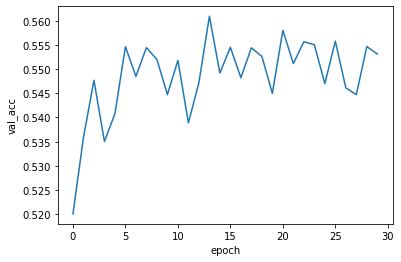

In [43]:
plt.plot(range(len(val_acc_history)), val_acc_history)
plt.xlabel('epoch')
plt.ylabel('val_acc')
plt.show()

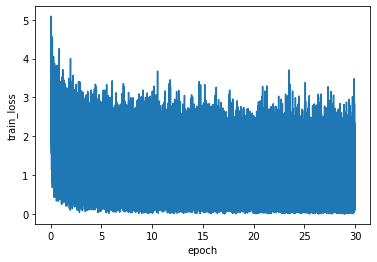

In [44]:
plt.plot([e / 5000 for e in range(len(train_loss_history))], train_loss_history)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.show()

In [46]:
torch.save({
    'epoch' : 30,
    'model_state_dict' : norm_model.state_dict(),
    'optimizer_state_dict' : norm_optimizer.state_dict(),    
}, 'saved_models/torch/subtask_5000t_32s')